# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### Question (a)
Here is a sanity check to verify the implementation of SimpleNN. 
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [3]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
CheckNet = SimpleNN()
CheckNet = CheckNet.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "CheckNet" to get output "out" 
out = CheckNet(data)   #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")


# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "CheckNet" to get output "out" 
out = CheckNet(data)     #Your code here

# Iterate through all the CONV and FC layers of the model
for name, module in CheckNet.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        # Get the weight of the module as a NumPy array
        wei_np = module.weight.detach().cpu().numpy()    #Your code here
        
        # Compute the number of parameters in the weight
        # Compute the number of MACs in the layer
        if isinstance(module, nn.Conv2d) :
            num_Param = len(wei_np[:,0,0,0]) * len(wei_np[0,:,0,0]) * len(wei_np[0,0,:,0]) * len(wei_np[0,0,0,:])
        if isinstance(module, nn.Linear) :
            num_Param = len(wei_np[:,0]) * len(wei_np[0,:])
        
        print(f'{name:10} {str(wei_np.shape):20} {str(num_Param):10} ')
#############################################

Run on GPU...
Forward pass successful
conv1      (8, 3, 5, 5)         600        
conv2      (16, 8, 3, 3)        1152       
fc1        (120, 576)           69120      
fc2        (84, 120)            10080      
fc3        (10, 84)             840        


## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [4]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                           (0.2023, 0.1994, 0.2010))])

transform_val = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                         (0.2023, 0.1994, 0.2010))])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [6]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train     # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val       # your code
)

#print(train_set.data)
print(type(train_set.data))

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,                # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,    # your code
    shuffle=False,               # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data\cifar10_trainval_F21.zip
Extracting ./data\cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_trainval_F21.zip
Extracting ./data\cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
<class 'numpy.ndarray'>


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [6]:
# specify the device for computation
#############################################
# your code here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

net = SimpleNN()
net = net.to(device)
    
#############################################

cuda


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [7]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), 
                      lr = INITIAL_LR, 
                      momentum = MOMENTUM, 
                      weight_decay = REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


In [8]:
# some hyperparameters
# total number of training epochs
EPOCHS = 30

# learning rate decay policy
#DECAY_EPOCHS = 10
#DECAY = 1.0

# Question (h) Bonus - Learning Rate Decay
DECAY_EPOCHS = 5
DECAY = 0.9

train_loss_list = list()
train_acc_list = list()
eva_loss_list = list()
eva_acc_list = list()

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    #######################
    # your code here
    # switch to train mode
    net.train()
    
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets.long())
        if i == 0 :
            if batch_idx == 0 :
                print("Initial Loss = " + str(loss))
        
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()
        
        total_examples = total_examples + targets.shape[0]
        train_loss = train_loss + loss
        correct_examples = correct_examples + correct.item()
        
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()
    
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets.long())
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            total_examples = total_examples + targets.shape[0]
            val_loss = val_loss + loss
            correct_examples = correct_examples + correct.item()
            
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    eva_loss_list.append(avg_loss)
    eva_acc_list.append(avg_acc)
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'simplenn.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Initial Loss = tensor(2.3012, device='cuda:0', grad_fn=<NllLossBackward>)
Training loss: 1.8770, Training accuracy: 0.3116
Validation loss: 1.5637, Validation accuracy: 0.4318
Saving ...

Epoch 1:
Training loss: 1.4293, Training accuracy: 0.4820
Validation loss: 1.3264, Validation accuracy: 0.5116
Saving ...

Epoch 2:
Training loss: 1.2546, Training accuracy: 0.5539
Validation loss: 1.2383, Validation accuracy: 0.5670
Saving ...

Epoch 3:
Training loss: 1.1340, Training accuracy: 0.6004
Validation loss: 1.1399, Validation accuracy: 0.6034
Saving ...

Epoch 4:
Training loss: 1.0389, Training accuracy: 0.6331
Validation loss: 1.1143, Validation accuracy: 0.6082
Saving ...

Current learning rate has decayed to 0.009000
Epoch 5:
Training loss: 0.9510, Training accuracy: 0.6667
Validation loss: 1.0240, Validation accuracy: 0.6386
Saving ...

Epoch 6:
Training loss: 0.9029, Training accuracy: 0.6836
Validation loss: 1.0434, Validation accuracy: 0.6312

Epoch 7:


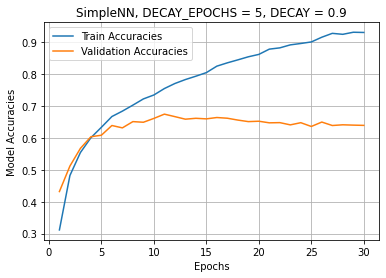

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
'''
x_epochs = ['1',  '2',  '3',  '4',  '5', 
            '6',  '7',  '8',  '9',  '10', 
            '11', '12', '13', '14', '15', 
            '16', '17', '18', '19', '20',
            '21', '22', '23', '24', '25', 
            '26', '27', '28', '29', '30']
'''

x_epochs = np.arange(1, 31, 1)
figure, axis = plt.subplots()

axis.plot(x_epochs, train_acc_list, label = "Train Accuracies")
axis.plot(x_epochs, eva_acc_list, label = "Validation Accuracies")

'''
for epoch, train_acc in zip(x_epochs, train_acc_list) :
    axis.annotate(str(train_acc), xy = (epoch, train_acc))
for epoch, eva_acc in zip(x_epochs, eva_acc_list) :
    if eva_acc == max(eva_acc_list) :
        axis.annotate("max eva acc = " + str(eva_acc), xy = (epoch, eva_acc))
        axis.annotate(str(eva_acc), xy = (epoch, eva_acc))
'''

axis.set(xlabel = "Epochs", ylabel = "Model Accuracies", 
         title = "SimpleNN, DECAY_EPOCHS = 5, DECAY = 0.9")
axis.grid()
# plt.yscale("log")
plt.legend()
plt.show()